# Deep Learning: Final Project

In [52]:
!pip install torch torchvision numpy matplotlib

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/40/b8/53fa08a5eaf78d3a7213fd6da1feec4bae14a81d9805e567013811ff0e85/matplotlib-3.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached matplotlib-3.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/c2/f3/20c5d1ef4f4748e52d60771b8560cf00b69d5c6368b5c2e9311bcfa2a08b/contourpy-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached contourpy-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.5 kB)
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Obtaining dep

In [81]:
import torchvision
import numpy as np
import torch
from torch.utils.data import DataLoader
import json
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

### Download pre-trained model

In [3]:
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')

### Setup dataset

In [4]:
!unzip -n TestDataSet.zip

Archive:  TestDataSet.zip


In [5]:
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])
plain_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize(mean=mean_norms, std=std_norms) 
])

batch_size = 128
dataset_path = "./TestDataSet"
dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=plain_transforms)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [56]:
# Load label mapping
with open(dataset_path + '/labels_list.json', "r") as f:
    label_list = json.load(f)
class_idx = [int(label.split(': ')[0]) for label in label_list]
class_label = [label.split(': ')[1] for label in label_list]

# map imagenet index to labels
imagenet_class_mapping = {idx: label for idx, label in zip(class_idx, class_label)}

# map dataset target to imagenet target
target_to_imagenet = {target: idx for target, idx in enumerate(class_idx)}

### Task 1: Evaluate pre-trained model

In [7]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pretrained_model = pretrained_model.to(device)
pretrained_model.eval()

top1_correct = 0
top5_correct = 0
total = 0

with torch.no_grad():
    for images, targets in dataloader:
        images = images.to(device)
        targets = targets.to(device)
        # map targets from test dataset to imagenet predictions
        imagenet_targets = torch.tensor(
            [target_to_imagenet[int(t)] for t in targets], device=device
        )

        # get preds
        outputs = pretrained_model(images)
        _, top5_preds = outputs.topk(5, dim=1)

        # Top-1 accuracy
        top1_correct += (top5_preds[:, 0] == imagenet_targets).sum().item()

        # Top-5 accuracy
        for i in range(images.size(0)):
            if imagenet_targets[i].item() in top5_preds[i]:
                top5_correct += 1

        total += images.size(0)

# Compute accuracy
top1_acc = top1_correct / total
top5_acc = top5_correct / total

print(f"Top-1 Accuracy: {top1_acc * 100:.2f}%")
print(f"Top-5 Accuracy: {top5_acc * 100:.2f}%")

Top-1 Accuracy: 76.00%
Top-5 Accuracy: 94.20%


### Task 2: Pixel-wise attacks

https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

In [82]:
fgsm_output_dir = "./AdversarialTestSet1"
os.makedirs(fgsm_output_dir, exist_ok=True)

In [75]:
fgsm_dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
epsilon = 0.02 / std_norms
epsilon_tensor = torch.tensor(epsilon).view(1, 3, 1, 1).to(device)

In [76]:
# FGSM attack
def fgsm_attack(image, label, model, epsilon_tensor):
    image.requires_grad = True
    output = model(image)
    loss = F.cross_entropy(output, label)
    model.zero_grad()
    loss.backward()
    data_grad = image.grad.data

    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon_tensor * sign_data_grad
    min_vals = torch.tensor((0 - mean_norms) / std_norms, dtype=torch.float32, device=image.device).view(1, 3, 1, 1)
    max_vals = torch.tensor((1 - mean_norms) / std_norms, dtype=torch.float32, device=image.device).view(1, 3, 1, 1)

    return torch.clamp(perturbed_image, min=min_vals, max=max_vals).to(dtype=torch.float32)

In [77]:
# Attack loop
adv_images = []
adv_labels = []
original_images = []

for i, (image, label) in enumerate(fgsm_dataloader):
    image, label = image.to(device), label.to(device)
    # map targets from test dataset to imagenet predictions
    imagenet_label = torch.tensor([target_to_imagenet[int(label.item())]], device=device)

    adv_image = fgsm_attack(image.clone(), imagenet_label, pretrained_model, epsilon_tensor)
    adv_images.append(adv_image.squeeze(0).cpu())
    adv_labels.append(imagenet_label.item())
    original_images.append(image.squeeze(0).cpu())


In [ ]:
# Save images
from pathlib import Path

def denormalize(image, mean_norms=mean_norms, std_norms=std_norms):
    """Normalize image tensor using mean/std."""
    mean = torch.tensor(mean_norms).view(1, 3, 1, 1).to(image.device)
    std = torch.tensor(std_norms).view(1, 3, 1, 1).to(image.device)
    return torch.clamp(image * std + mean, 0, 1)

# Get original image file paths from the dataset
original_paths = [Path(dataset.imgs[i][0]) for i in range(len(dataset))]

# Save loop
for i, (img, orig_path) in enumerate(zip(adv_images, original_paths)):
    # Determine relative path inside dataset
    rel_path = orig_path.relative_to(dataset.root)
    save_path = Path(fgsm_output_dir) / rel_path

    # Make directory if needed
    save_path.parent.mkdir(parents=True, exist_ok=True)

    # Convert and save
    img_denorm = denormalize(img).squeeze(0)
    pil_img = TF.to_pil_image(img_denorm)
    pil_img.save(save_path)

In [ ]:
max_diff = 0

for orig, adv in zip(original_images, adv_images):
    denorm_orig = denormalize(orig)
    denorm_adv = denormalize(adv)
    diff = torch.abs(denorm_orig - denorm_adv)
    max_diff = max(max_diff, diff.max().item())

print(rf"Max L_inf pixel difference: {max_diff:.5f}")

Max L_inf pixel difference: 0.02000


In [91]:
def show_adversarial_example(orig_img, adv_img, model):
    model.eval()
    # Denormalize for visualization
    def denorm(t):
        mean = torch.tensor(mean_norms).view(3, 1, 1)
        std = torch.tensor(std_norms).view(3, 1, 1)
        return torch.clamp(t.cpu() * std + mean, 0, 1)

    orig_disp = denorm(orig_img)
    adv_disp = denorm(adv_img)

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(TF.to_pil_image(orig_disp))
    axs[0].set_title(f"Original")
    axs[1].imshow(TF.to_pil_image(adv_disp))
    axs[1].set_title(f"Adversarial")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


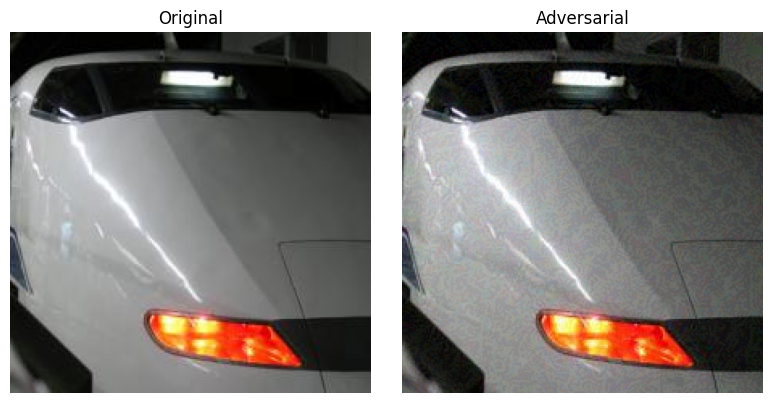

In [97]:
# show a random sample
from random import randint

index = randint(0, 500)
show_adversarial_example(original_images[index], adv_images[index], pretrained_model)


In [49]:
correct1 = 0
correct5 = 0
total = len(adv_images)

with torch.no_grad():
    for img, label in zip(adv_images, adv_labels):
        input_img = img.unsqueeze(0).to(device)
        label = torch.tensor([label], device=device)
        output = pretrained_model(input_img)
        _, top5 = output.topk(5, dim=1)
        correct1 += (top5[:, 0] == label).sum().item()
        correct5 += (label.item() in top5[0].tolist())

print(f"Adversarial Top-1 Accuracy: {100 * correct1 / total:.2f}%")
print(f"Adversarial Top-5 Accuracy: {100 * correct5 / total:.2f}%")

Adversarial Top-1 Accuracy: 3.60%
Adversarial Top-5 Accuracy: 20.80%
